In [132]:
from notebook_utils import resolve_paths_from_parent_directory
resolve_paths_from_parent_directory()
# auto reload notebook deps
%reload_ext autoreload
%autoreload 2

In [133]:
import json
import pandas as pd

DATASETS = {
    "CentralParkNYC": {
        "input_location": "../data/tweet_objects/CentralParkNYC/2021-01-27-2021-02-06.json",
        "output_location": "../data/labeled_datasets/CentralParkNYC-2021-01-27-2021-02-06.json",
        "spike_start": "Feb 1, 2021, 17:00",
        "spike_end": "Feb 3, 2021, 04:00",
    },
    "united": {
        "input_location": "../data/tweet_objects/united/2020-12-05-2020-12-15.json",
        "output_location": "../data/labeled_datasets/united-2020-12-05-2020-12-15.json",
        "spike_start": "Dec 12, 2020, 05:00",
        "spike_end": "Dec 13, 2020, 06:00",
    },
    "nationalGridUS": {
        "input_location": "../data/tweet_objects/nationalGridUS/2020-10-01-2020-10-12.json",
        "output_location": "../data/labeled_datasets/nationalGridUS-2020-10-01-2020-10-12.json",
        "spike_start": "Oct 7, 2020, 17:00",
        "spike_end": "Oct 9, 2020, 04:00",
    }
}

selected_dataset = DATASETS["united"]
labeled_spike_start = pd.to_datetime(selected_dataset["spike_start"]).tz_localize("UTC")
labeled_spike_end = pd.to_datetime(selected_dataset["spike_end"]).tz_localize("UTC")

In [134]:
from utils.dataset import create_tweet_df

with open(selected_dataset["input_location"], "r") as f:
    raw_dataset = json.load(f)

df_tweets = create_tweet_df(raw_dataset["tweets"])

# lower entities
df_tweets["hashtags"] = df_tweets.hashtags.apply(lambda xs: [x.lower() for x in xs])
df_tweets["mentions"] = df_tweets.mentions.apply(lambda xs: [x.lower() for x in xs])

# Set retweet count 0 for retweets
df_tweets["retweet_count"] = df_tweets.apply(
    lambda x: x.retweet_count if x.retweeted is None else 0, 
    axis=1
)

# Label tweets
df_tweets["is_anomaly"] = df_tweets.created_at.apply(
    lambda x: 0 if (x < labeled_spike_start or x > labeled_spike_end) else 1
)

df_tweets.head()

,id,text,created_at,hashtags,mentions,in_reply_to_user_id,user_id,retweet_count,quote_count,reply_count,like_count,replied_to,retweeted,quoted,is_anomaly
34642,1336444683875016705,"RT @DavidCornDC: Hey @United, a family member ...",2020-12-08 22:56:57+00:00,[],"[davidcorndc, united]",None,779922519285301248,0,0,0,0,NaN,1336361619107049472,NaN,0
34641,1336444690640465920,"RT @DavidCornDC: Hey @United, a family member ...",2020-12-08 22:56:58+00:00,[],"[davidcorndc, united]",None,161003217,0,0,0,0,NaN,1336361619107049472,NaN,0
34640,1336444721556668416,"RT @DavidCornDC: Worse, @United, your flight a...",2020-12-08 22:57:06+00:00,[],"[davidcorndc, united]",None,161003217,0,0,0,0,NaN,1336361619857809408,NaN,0
34639,1336444729723064320,"RT @DavidCornDC: Worse, @United, your flight a...",2020-12-08 22:57:08+00:00,[],"[davidcorndc, united]",None,794448786,0,0,0,0,NaN,1336361619857809408,NaN,0
34638,1336444732554113024,"RT @DavidCornDC: Hey @United, a family member ...",2020-12-08 22:57:08+00:00,[],"[davidcorndc, united]",None,1165791085626396672,0,0,0,0,NaN,1336361619107049472,NaN,0


In [135]:
## Create timeseries from tweets
from utils.dataset import count_array_column

df_top_hashtags = count_array_column(df_tweets["hashtags"])
df_top_mentions = count_array_column(df_tweets["mentions"])

df_top_hashtags[:5]

,value,count,pct
7,boycottunitedairlines,313,0.009035
10,unitedairlines,277,0.007996
33,boycottunited,166,0.004792
63,covid19,87,0.002511
18,travel,78,0.002252


In [136]:
def count_col_occurrence(df_col, value):
    return df_col.apply(lambda values: value in values).sum()

time_bucket_size = "30Min"

df_timeseries = df_tweets.groupby(df_tweets.created_at.dt.ceil(time_bucket_size)).agg(
    total_count=('id', 'count'), 
    is_anomaly=('is_anomaly', lambda x: x.any()),
    retweet_count=('retweeted', lambda x: pd.notna(x).sum()),
    quote_count=('quoted', lambda x: pd.notna(x).sum()),
    replied_to_count=('replied_to', lambda x: pd.notna(x).sum()),
    top1_hashtag_count=(
        'hashtags', 
        lambda x: count_col_occurrence(x, df_top_hashtags.iloc[0].value)
    ),
    top2_hashtag_count=(
        'hashtags', 
        lambda x: count_col_occurrence(x, df_top_hashtags.iloc[1].value)
    ),
    top3_hashtag_count=(
        'hashtags', 
        lambda x: count_col_occurrence(x, df_top_hashtags.iloc[2].value)
    ),
    top1_mention_count=(
        'mentions', 
        lambda x: count_col_occurrence(x, df_top_mentions.iloc[0].value)
    ),
    top2_mention_count=(
        'mentions', 
        lambda x: count_col_occurrence(x, df_top_mentions.iloc[1].value)
    ),
    top3_mention_count=(
        'mentions', 
        lambda x: count_col_occurrence(x, df_top_mentions.iloc[2].value)
    )
)
df_timeseries.head()

,total_count,is_anomaly,retweet_count,quote_count,replied_to_count,top1_hashtag_count,top2_hashtag_count,top3_hashtag_count,top1_mention_count,top2_mention_count,top3_mention_count
created_at,,,,,,,,,,,
2020-12-08 23:00:00+00:00,51,False,45,1,5,0,0,0,51,0,49
2020-12-08 23:30:00+00:00,358,False,269,12,71,1,1,0,352,0,320
2020-12-09 00:00:00+00:00,386,False,311,11,64,0,0,0,384,0,356
2020-12-09 00:30:00+00:00,255,False,213,4,36,0,0,0,250,0,238
2020-12-09 01:00:00+00:00,229,False,177,7,38,0,1,0,222,0,199


2021-10-08 08:40:44,715 merlion.models.forecast.prophet INFO     Add seasonality 21
2021-10-08 08:40:44.722 INFO    fbprophet: Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2021-10-08 08:40:44.723 INFO    fbprophet: Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Initial log joint probability = -21.274
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       637.426     0.0144965       94.0026       0.577       0.577      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       639.449    0.00223588        100.75   2.274e-05       0.001      191  LS failed, Hessian reset 
     182       639.793   0.000431564       118.202   3.568e-06       0.001      294  LS failed, Hessian reset 
     199       639.867   0.000404538       81.2471           1           1      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     249       639.993    3.4434e-05       99.4726   3.447e-07       0.001      402  LS failed, Hessian reset 
     285       639.995    9.2816e-09       103.711      0.3037    0.003037      452   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was b

2021-10-08 08:40:54.978 INFO    fbprophet: Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2021-10-08 08:40:54.979 INFO    fbprophet: Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Initial log joint probability = -3.85735
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       603.935   1.60911e-06       100.492      0.6344      0.6344      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       603.935   1.04633e-08        101.25      0.2709           1      156   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


2021-10-08 08:41:04.151 INFO    fbprophet: Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2021-10-08 08:41:04.151 INFO    fbprophet: Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Initial log joint probability = -10.2972
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       404.896   2.38092e-07       100.989      0.3213           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       404.923   1.71101e-08       100.403      0.3874           1      209   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


2021-10-08 08:41:13,922 merlion.models.forecast.prophet INFO     Add seasonality 28
2021-10-08 08:41:13.930 INFO    fbprophet: Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2021-10-08 08:41:13.930 INFO    fbprophet: Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Initial log joint probability = -3.24953
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      45        682.74   1.50382e-08       99.9506      0.3431      0.3431       63   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


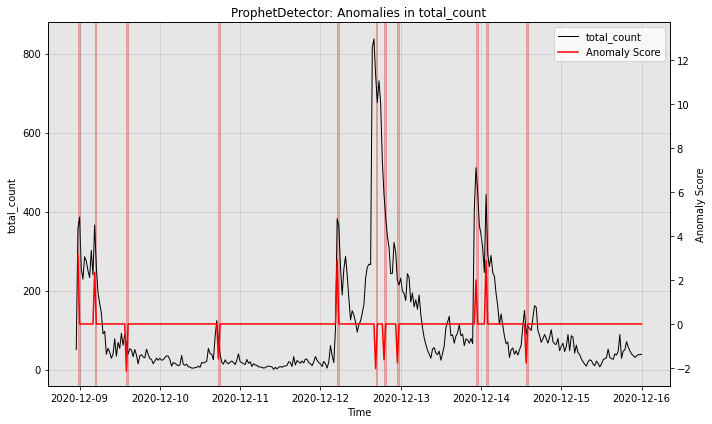

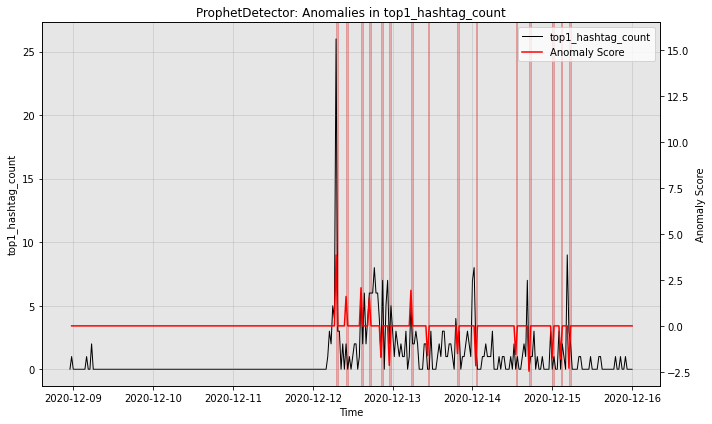

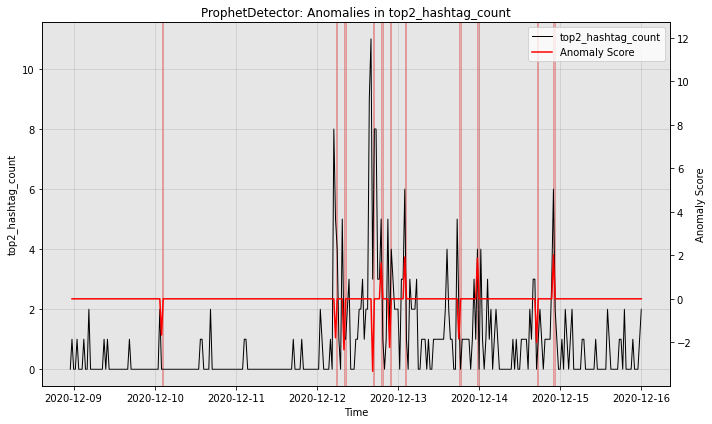

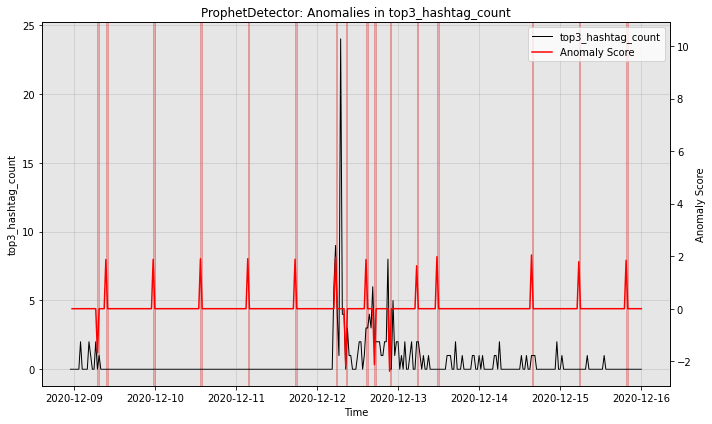

In [137]:

from merlion.utils import TimeSeries
from merlion.models.anomaly.forecast_based.prophet import ProphetDetector, ProphetDetectorConfig

def convert_to_merlion(df, column):
    df = df.copy()
    df = df[column]
    df.index = df.index.tz_convert(None)
    return TimeSeries.from_pd(df)

for feat in ["total_count", "top1_hashtag_count", "top2_hashtag_count", "top3_hashtag_count"]:
    train_data = convert_to_merlion(df_timeseries, feat)

    model = ProphetDetector(ProphetDetectorConfig())
    model.threshold.alm_threshold = 1.5
    anomaly_score = model.train(train_data=train_data, anomaly_labels=None)
    scores = model.get_anomaly_score(train_data)
    df_scores = scores.to_pd()
    labels_train = model.get_anomaly_label(train_data)

    from merlion.plot import plot_anoms
    import matplotlib.pyplot as plt
    fig, ax = model.plot_anomaly(time_series=train_data)
    plot_anoms(ax=ax, anomaly_labels=labels_train)

    df_labels = labels_train.to_pd()
    df_labels.resample('30Min').fillna("bfill")

    def set_anom_score(created_at):
        lookup = created_at.tz_convert(None).ceil("30Min")
        if lookup in df_labels.index:
            return df_labels.loc[lookup].anom_score
        else:
            return 0

    ## Label df_tweets with anomaly
    df_tweets["merlion_anomaly_" + feat] = df_tweets.created_at.apply(
        set_anom_score
    )

In [138]:
# Export 
df_tweets.to_json(
    selected_dataset["output_location"],
    orient="records"
)
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34643 entries, 34642 to 0
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype              
---  ------                              --------------  -----              
 0   id                                  34643 non-null  object             
 1   text                                34643 non-null  object             
 2   created_at                          34643 non-null  datetime64[ns, UTC]
 3   hashtags                            34643 non-null  object             
 4   mentions                            34643 non-null  object             
 5   in_reply_to_user_id                 15238 non-null  object             
 6   user_id                             34643 non-null  object             
 7   retweet_count                       34643 non-null  int64              
 8   quote_count                         34643 non-null  int64              
 9   reply_count                         346